In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import shap

In [2]:
col_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 
             'dst_bytes','land', 'wrong_fragment', 'urgent', 'hot', 
             'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
             'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
             'num_access_files', 'num_outbound_cmds', 'is_host_login', 
             'is_guest_login', 'count', 'srv_count', 'serror_rate', 
             'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
             'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 
             'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 
             'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
             'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
             'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
             'dst_host_srv_rerror_rate', 'label']

In [3]:
df = pd.read_csv("/kaggle/input/kdd-cup-1999-data/kddcup.data.gz", names=col_names)

In [4]:
label_mapping = {
    'back.': 1, 'land.': 1, 'neptune.': 1, 'pod.': 1, 'smurf.': 1, 'teardrop.': 1, 'apache2.': 1,
    'udpstorm.': 1, 'processtable.': 1, 'worm.': 1,
    
    'satan.': 2, 'ipsweep.': 2, 'nmap.': 2, 'portsweep.': 2, 'mscan.': 2, 'saint.': 2,
    
    'guess_passwd.': 3, 'ftp_write.': 3, 'imap.': 3, 'phf.': 3, 'multihop.': 3, 'warezmaster.': 3,
    'warezclient.': 3, 'spy.': 3, 'xlock.': 3, 'xsnoop.': 3, 'snmpguess.': 3, 'snmpgetattack.': 3,
    'httptunnel.': 3, 'sendmail.': 3, 'named.': 3, 'mailbomb.': 3,
    
    'buffer_overflow.': 3, 'loadmodule.': 3, 'rootkit.': 3, 'perl.': 3, 'sqlattack.': 3,
    'xterm.': 3, 'ps.': 3,
    
    'normal.': 0
}

df['label'] = df['label'].replace(label_mapping)

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [5]:
num_cols = df._get_numeric_data().columns
cate_cols = list(set(df.columns)-set(num_cols))

category_mapping_truncated = {}
for category in cate_cols:
    labels, unique_values = pd.factorize(df[category])
    df[category] = labels
    category_mapping_truncated[category] = dict(zip(set(unique_values), set(labels)))

In [6]:
class DeviceDL():
    
    def __init__(self, dl, dev):
        self.dl = dl
        self.dev = dev
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.dev)
            
    def __len__(self):
        return len(self.dl)

In [7]:
X = torch.tensor(df.drop('label',axis=1).values.astype(np.float32))
y = torch.tensor(df['label'].values, dtype=torch.long)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(d, device) for d in data]
    return data.to(device, non_blocking=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
train_ds,valid_ds = TensorDataset(X_train, y_train), TensorDataset(X_test, y_test)
# Make a dataloader
BATCH = 1024
valid_dl = DataLoader(valid_ds, batch_size=BATCH, shuffle=False)

valid_dl = DeviceDL(valid_dl, device)

In [8]:
class BaseNet(nn.Module):
    def get_loss(self, batch, loss_fn):
        features,labels = batch
        preds = self(features)
        loss = loss_fn(preds, labels)
        return loss
    
    def validate(self, batch, loss_fn):
        feature, labels = batch
        loss = self.get_loss(batch, loss_fn)
        pred = self(feature)
        
        acc = accuracy(labels, pred)
        return {'valid_loss' : loss , 'valid_acc' : acc}
    
    def average_validation(self, out):
        loss = torch.stack([l['valid_loss'] for l in out]).mean()
        acc = torch.stack([l['valid_acc'] for l in out]).mean()
        return {'valid_loss': loss.item() , 'valid_acc': acc.item()}
    
    def log_epoch(self, e, epoch, res):
        
        print('[{} / {}] epoch/s, training loss is {:.4f} validation loss is {:.4f}, validation accuracy is {:.4f} '\
              .format(e+1,epoch,
                      res['train_loss'],
                      res['valid_loss'],                
                      res['valid_acc']
                     )
             )

In [9]:
class ClassifierMLP(BaseNet):
    
    def __init__(self, activation, input_dim, hidden_1, hidden_2, out):
        super().__init__()
        self.hidden_1 = nn.Linear(input_dim, hidden_1)
        self.hidden_2 = nn.Linear(hidden_1, hidden_2)
        self.out = nn.Linear(hidden_2, out)
        self.activation = activation
        
    def forward(self, x):
        x1 = self.hidden_1(x)
        x2 = self.activation(x1)
        x3 = self.hidden_2(x2)
        x4 = self.activation(x3)
        out = self.out(x4)
        
        return out

In [10]:
activation = nn.ReLU()
input_dim = X.shape[1]
output_dim = df['label'].nunique()
hidden_1, hidden_2 = 128, 64


model = ClassifierMLP(activation, input_dim, hidden_1, hidden_2, output_dim)
to_device(model, device)

ClassifierMLP(
  (hidden_1): Linear(in_features=41, out_features=128, bias=True)
  (hidden_2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=4, bias=True)
  (activation): ReLU()
)

In [11]:
model.load_state_dict(torch.load("/kaggle/input/cil-pretrained-models-zero-day-ids/model_truncated_four_class.pth"))

<All keys matched successfully>

In [12]:
model.eval()

ClassifierMLP(
  (hidden_1): Linear(in_features=41, out_features=128, bias=True)
  (hidden_2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=4, bias=True)
  (activation): ReLU()
)

In [ ]:
shap.initjs()

In [ ]:
@torch.no_grad()
def f(X):
    return model(torch.tensor([X[:, i] for i in range(X.shape[1])]).to(device).T.unsqueeze(0)).cpu().numpy()[0]

In [ ]:
test_x = X_test[:50].cpu().numpy()


In [ ]:
col_names.remove('label')

In [17]:
explainer = shap.KernelExplainer(f, test_x, feature_names=col_names)
shap_values = explainer.shap_values(X_test[200:250,:].cpu().numpy(), nsamples=500, feature_names=col_names)

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)


  0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=col_names)

In [19]:
shap.force_plot(explainer.expected_value[1], shap_values[1], feature_names=col_names)


In [20]:
shap.force_plot(explainer.expected_value[2], shap_values[2], feature_names=col_names)


In [21]:
shap.force_plot(explainer.expected_value[3], shap_values[3], feature_names=col_names)


In [22]:
shap_values[0].shape

(50, 41)

In [23]:
category_mapping = ['Normal', 'Probe','DOS', 'UA']

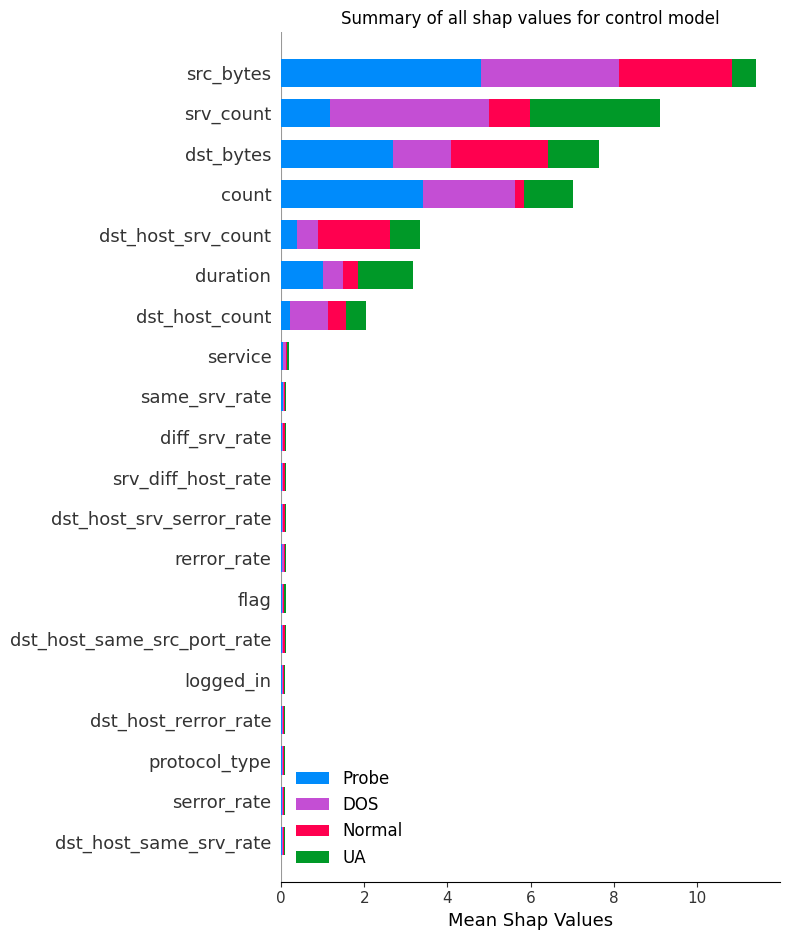

In [24]:
plt.figure(figsize=(30,20))
plt.title("Summary of all shap values for control model")
# plt.subplots_adjust(wspace=0.4, hspace=0.4)
shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=col_names, 
    class_names=category_mapping,
    show=False
)
plt.xlabel('Mean Shap Values')
plt.savefig("summary_control.png",bbox_inches='tight')

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


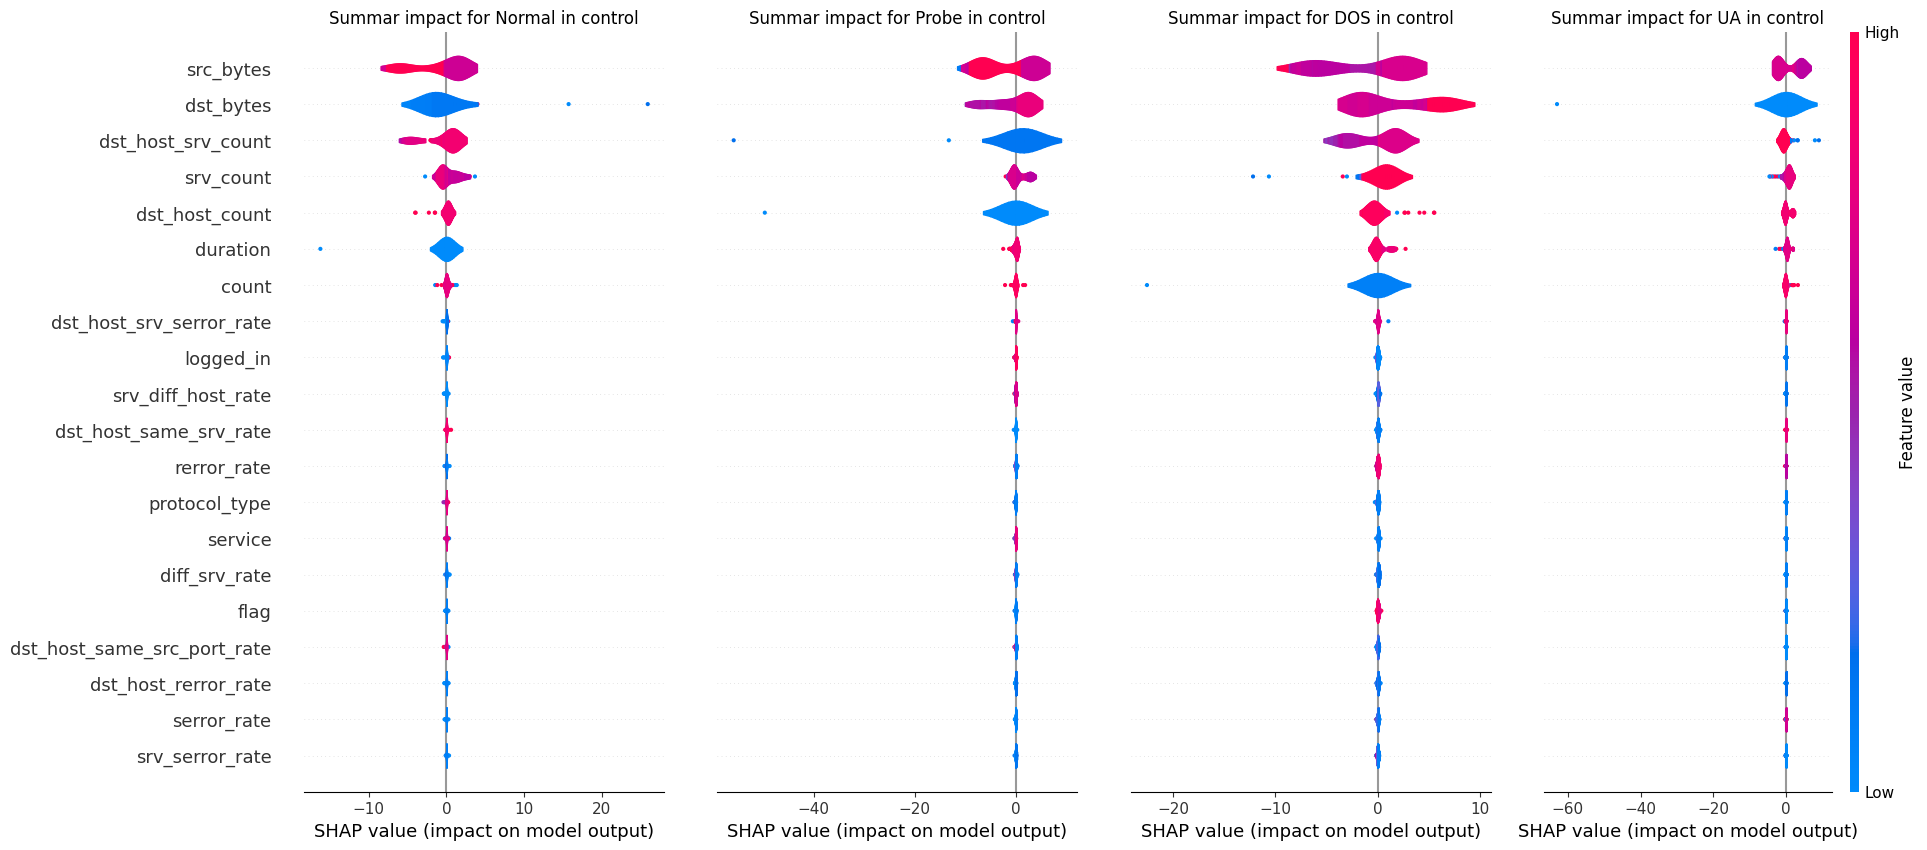

In [25]:
plt.figure()
plt.title("Each class summary for control")
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title(f"Summar impact for {category_mapping[i]} in control")
    color_bar = False if i<3 else True
    
    shap.summary_plot(
        shap_values[i], 
        test_x, 
        col_names, 
        plot_type="violin", 
        show=False, 
        color_bar=color_bar
    )   
    
    if i>0:
        plt.gca().axes.get_yaxis().set_visible(False)

plt.subplots_adjust(
    left=1,
    bottom=0.1, 
    right=3, 
    top=0.9
)
plt.savefig("summary_impact_control.png",bbox_inches='tight')

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


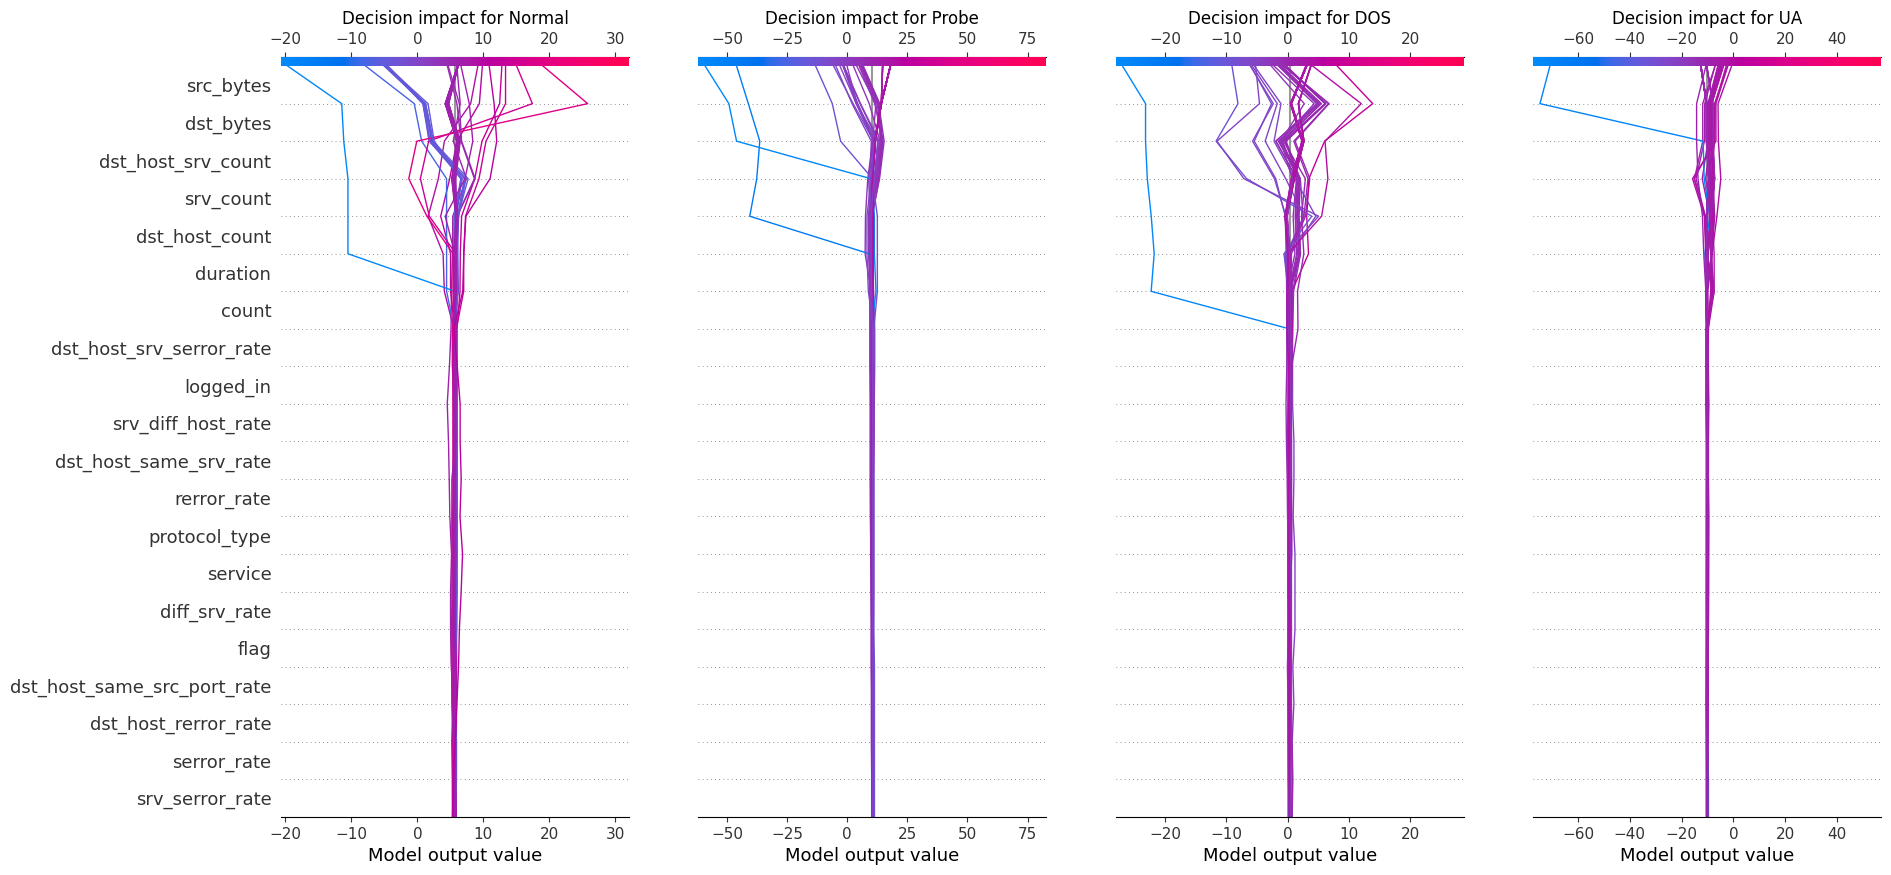

In [ ]:
plt.figure()
plt.title("Decision impact plot - Control")
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title(f"Decision impact for {category_mapping[i]}")
    shap.decision_plot(explainer.expected_value[i], shap_values[i], feature_names=col_names, show=False)
    if i>0:
        plt.gca().axes.get_yaxis().set_visible(False)

plt.subplots_adjust(
    left=1,
    bottom=0.1, 
    right=3, 
    top=0.9
)
plt.savefig("deicsion_impact_control.png",bbox_inches='tight')

In [27]:
model.load_state_dict(torch.load("/kaggle/input/cil-pretrained-models-zero-day-ids/model_truncated_weighted_four_class.pth"))

<All keys matched successfully>

In [28]:
model.eval()

ClassifierMLP(
  (hidden_1): Linear(in_features=41, out_features=128, bias=True)
  (hidden_2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=4, bias=True)
  (activation): ReLU()
)

In [29]:
explainer = shap.KernelExplainer(f, test_x, feature_names=col_names)
shap_values = explainer.shap_values(X_test[200:250,:].cpu().numpy(), nsamples=500, feature_names=col_names)

  0%|          | 0/50 [00:00<?, ?it/s]

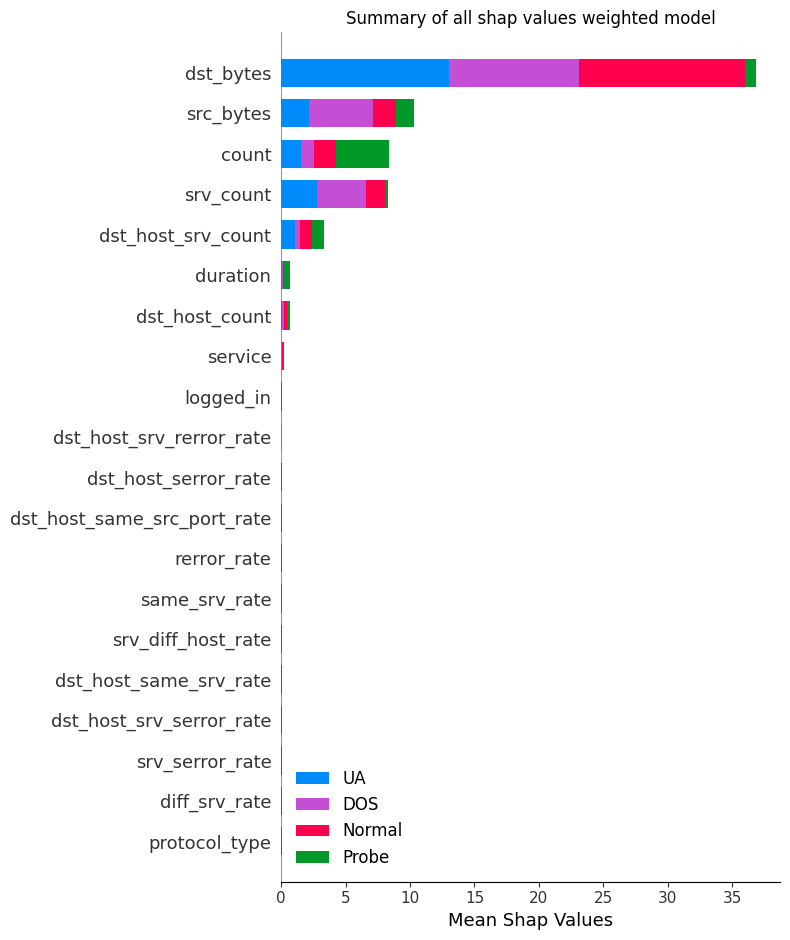

In [30]:
plt.figure(figsize=(30,20))
plt.title("Summary of all shap values weighted model")
# plt.subplots_adjust(wspace=0.4, hspace=0.4)
shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=col_names, 
    class_names=category_mapping,
    show=False
)
plt.xlabel('Mean Shap Values')
plt.savefig("summary_weighted.png",bbox_inches='tight')

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


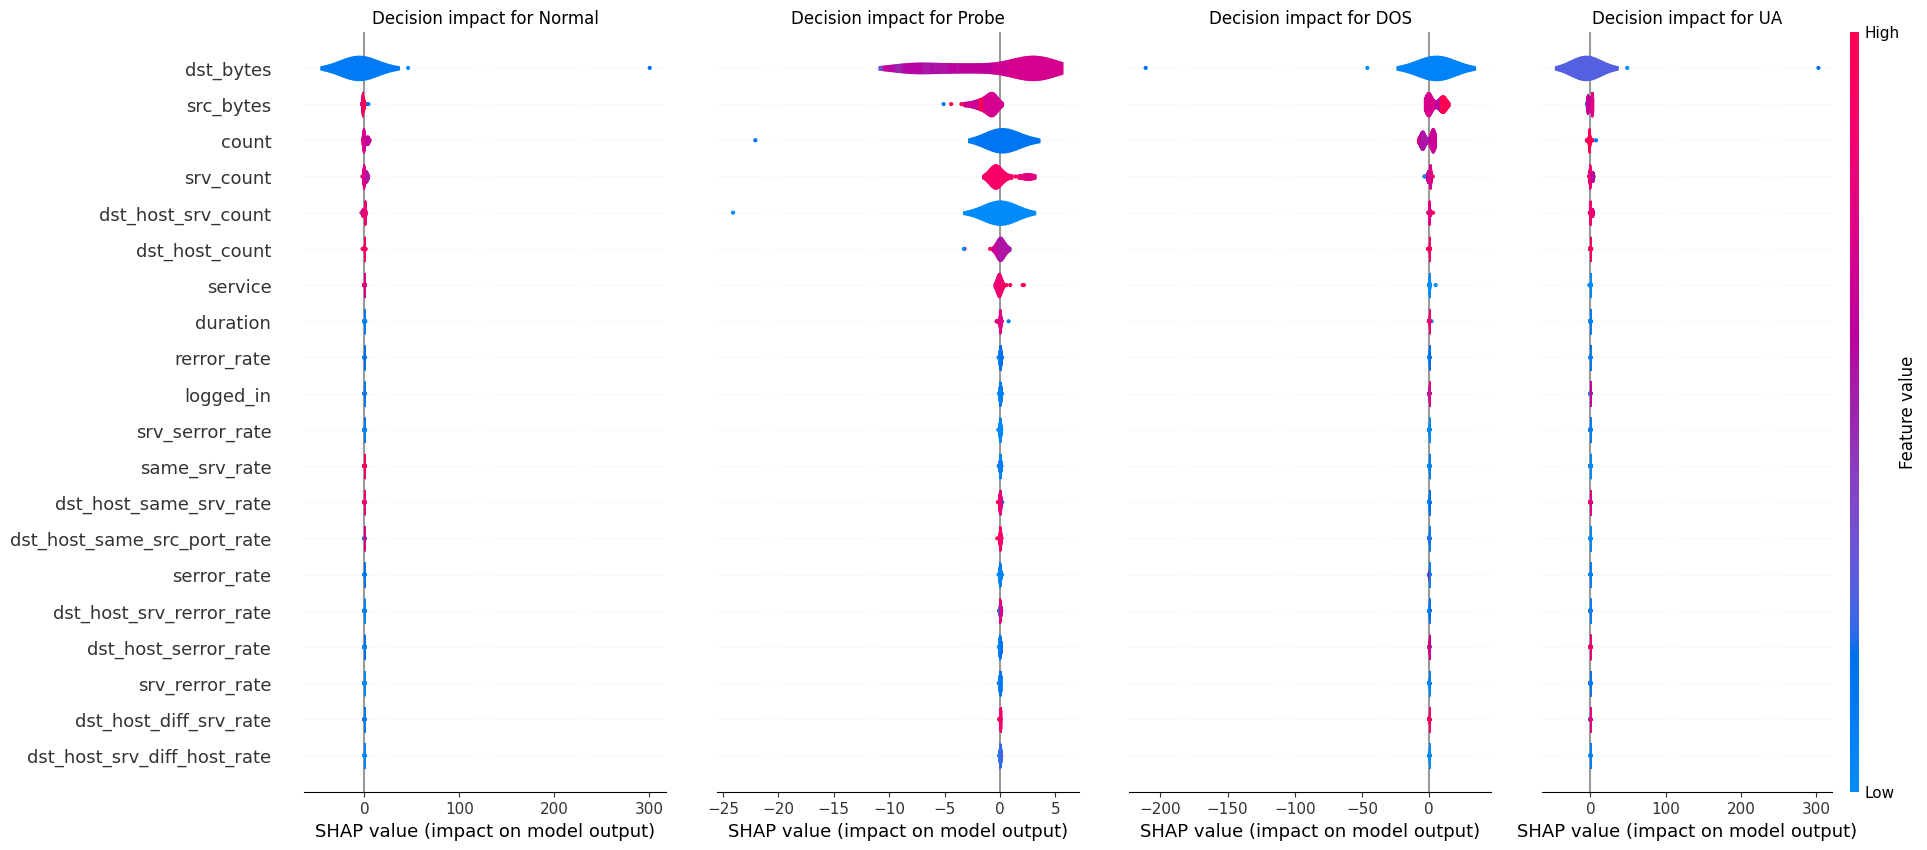

In [31]:
plt.figure()
plt.title("Each class summary of weighted")
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title(f"Decision impact for {category_mapping[i]}")
    color_bar = False if i<3 else True
    
    shap.summary_plot(
        shap_values[i], 
        test_x, 
        col_names, 
        plot_type="violin", 
        show=False, 
        color_bar=color_bar
    )   
    
    if i>0:
        plt.gca().axes.get_yaxis().set_visible(False)

plt.subplots_adjust(
    left=1,
    bottom=0.1, 
    right=3, 
    top=0.9
)
plt.savefig("summary_impact_weighted.png",bbox_inches='tight')

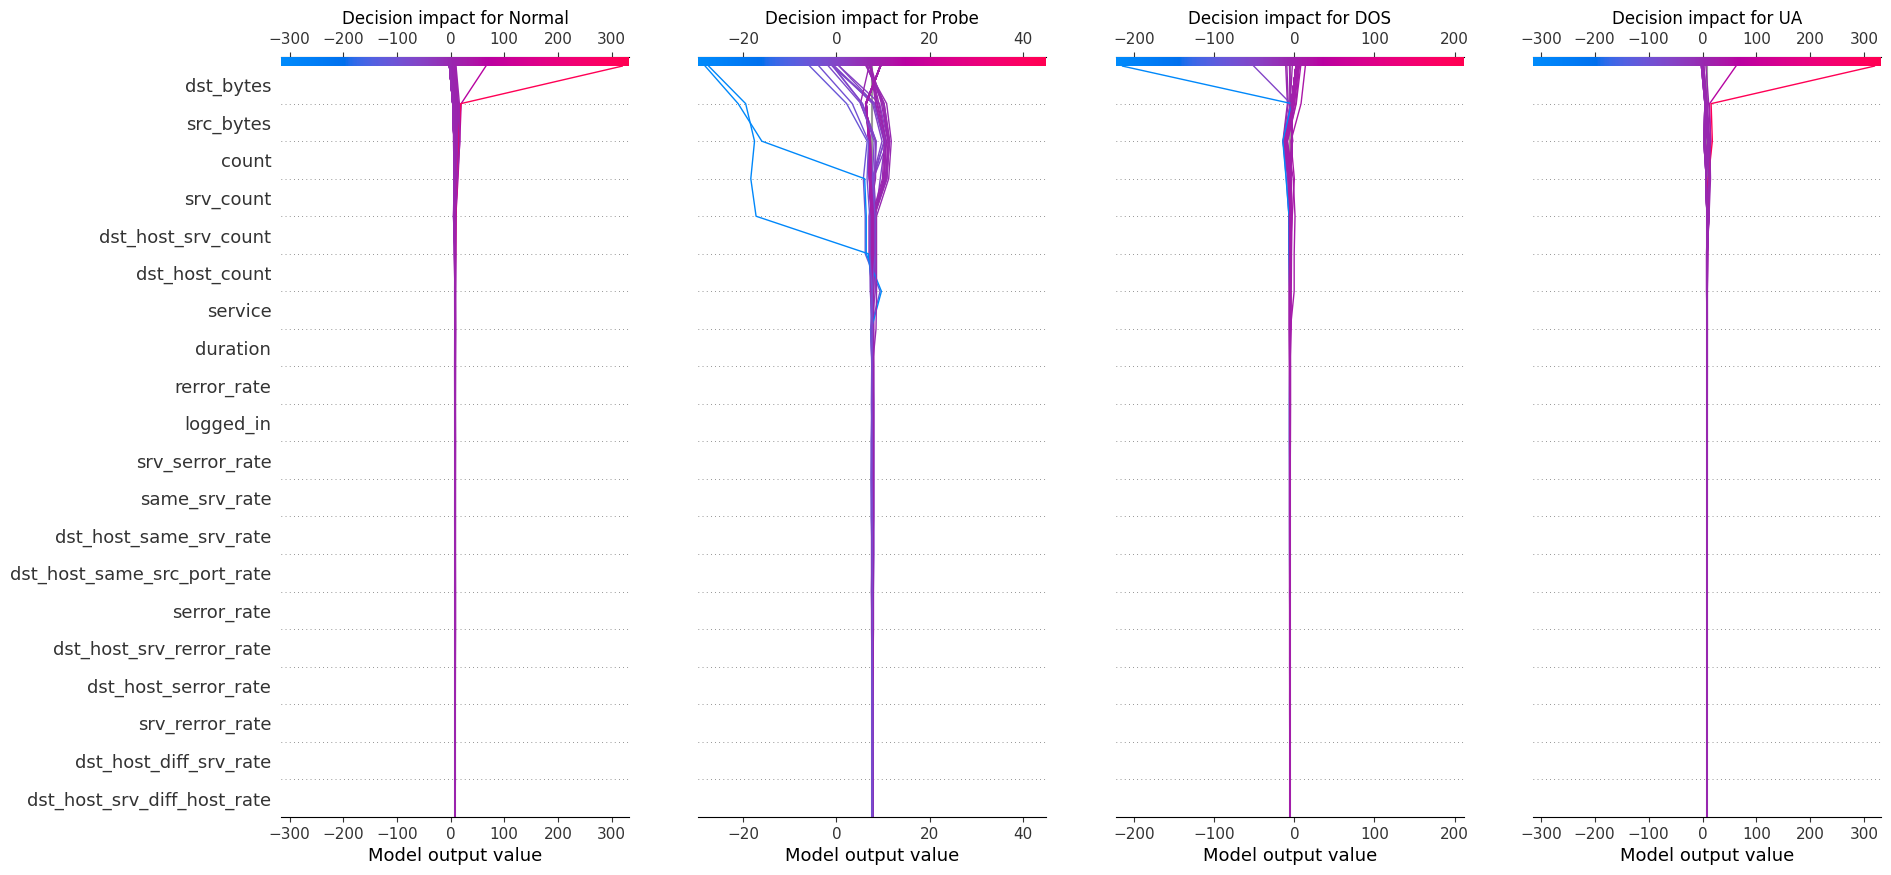

In [32]:
plt.figure()
# plt.title("Decision impact plot - Weighted")

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title(f"Decision impact for {category_mapping[i]}")
    shap.decision_plot(explainer.expected_value[i], shap_values[i], feature_names=col_names, show=False)
    if i>0:
        plt.gca().axes.get_yaxis().set_visible(False)

plt.subplots_adjust(
    left=1,
    bottom=0.1, 
    right=3, 
    top=0.9
)

plt.savefig("deicsion_impact_weighted.png",bbox_inches='tight')

In [33]:
!tar -cvzf shap_graphs.tar .

./
./summary_impact_control.png
./summary_control.png
./deicsion_impact_control.png
./.virtual_documents/
./summary_weighted.png
./summary_impact_weighted.png
./deicsion_impact_weighted.png
tar: .: file changed as we read it
